# Import Packages and Data

In [1]:
import pandas as pd
import numpy as np
from IPython.core.display import HTML
import numpy as np
import json
from sklearn.feature_extraction.text import TfidfTransformer
from scipy import sparse
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from pylab import *
from scipy import *
import matplotlib.pyplot as plt
import re
import math
import pandasql as ps
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

In [2]:
df_train = pd.read_json ('train.json')
df_train.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [3]:
#count of receipes for each cuisine
c=pd.DataFrame(df_train.groupby('cuisine')['id'].nunique())
c.reset_index(inplace=True)
c.rename(columns={'id':'recipe_count'},inplace=True)
c

,cuisine,recipe_count
0,brazilian,467
1,british,804
2,cajun_creole,1546
3,chinese,2673
4,filipino,755
5,french,2646
6,greek,1175
7,indian,3003
8,irish,667
9,italian,7838


In [4]:
display(HTML(df_train.head().to_html()))

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes, garlic, pepper, purple onion, seasoning, garbanzo beans, feta cheese crumbles]"
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, ground black pepper, thyme, eggs, green tomatoes, yellow corn meal, milk, vegetable oil]"
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, green chilies, grilled chicken breasts, garlic powder, yellow onion, soy sauce, butter, chicken livers]"
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pepper, onions, garlic paste, milk, butter, salt, lemon juice, water, chili powder, passata, oil, ground cumin, boneless chicken skinless thigh, garam masala, double cream, natural yogurt, bay leaf]"


# Clustering

C:\Users\mayan\Anaconda3\lib\site-packages\ipykernel_launcher.py:155: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


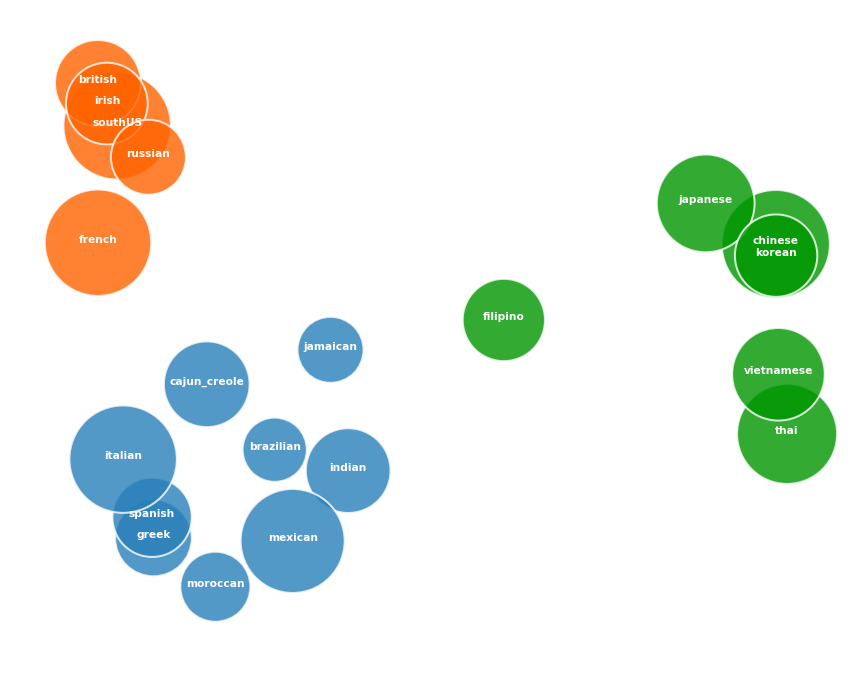

In [5]:
#Clustering
with open('train.json') as data_file:    
    data = json.load(data_file)


# To create a dictionary of ingredients per cuisine
def create_dict_cuisine_ingred(json):
    dictCuisineIngred = {}
    cuisines = []
    ingredients = []
    
    for i in range(len(json)):
        
        # To change southern_us to southUS for better visualization
        cuisine = json[i]['cuisine']
        if cuisine == 'southern_us':
            cuisine = 'southUS'

        ingredientsPerCuisine = json[i]['ingredients'] #list of ingreadients for each cuisine
        
        if cuisine not in dictCuisineIngred.keys(): 
            cuisines.append(cuisine)
            dictCuisineIngred[cuisine] = ingredientsPerCuisine
            
        else: 
            currentList = dictCuisineIngred[cuisine]
            currentList.extend(ingredientsPerCuisine)
            dictCuisineIngred[cuisine] = currentList
                 
        ingredients.extend(ingredientsPerCuisine)
         
    ingredients = list(set(ingredients)) # unique list of ALL ingredients
    numUniqueIngredients = len(ingredients)
    numCuisines = len(cuisines)
    
    return dictCuisineIngred, numCuisines, numUniqueIngredients, cuisines, ingredients


# Define function to prepare the data for tf-idf 
def create_term_count_matrix(dictionary, numCuisines, numIngred, cuisines, ingredients):
    termCountMatrix = np.zeros((numCuisines,numIngred))
    i = 0
    
    for cuisine in cuisines:
        ingredientsPerCuisine = dictCuisineIngred[cuisine]

        for ingredient in ingredientsPerCuisine:
            j = ingredients.index(ingredient) #in order to know which column to put the term count in, we will ago according to the terms' order in the ingredients array
            termCountMatrix[i,j] += 1

        i += 1

    return termCountMatrix
    

dictCuisineIngred, numCuisines, numIngred, cuisines, ingredients = create_dict_cuisine_ingred(data)
countsMatrix = create_term_count_matrix(dictCuisineIngred, numCuisines, numIngred, cuisines, ingredients)
            



get_ipython().magic(u'matplotlib inline')

# Define function to create the tf-idf matrix using a countsMatrix.
def tf_idf_from_count_matrix(countsMatrix):
    
    countsMatrix = sparse.csr_matrix(countsMatrix)
    transformer = TfidfTransformer()
    tfidf = transformer.fit_transform(countsMatrix) # normalizes vectors to mean 0 and std 1 and computes tf-idf
    tfidf.toarray() 
    return tfidf.toarray()

# tf-idf matrix
tfIdf_Matrix = tf_idf_from_count_matrix(countsMatrix)


# running PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
# print(pca.explained_variance_ratio_)   
reduced_data = pca.fit_transform(tfIdf_Matrix)

# converting to pandas dataframe for convenience
pca2dataFrame = pd.DataFrame(reduced_data)
pca2dataFrame.columns = ['PC1', 'PC2']


# KMEANS


def kmeans_cultures(numOfClusters):
    
    kmeans = KMeans(init='k-means++', n_clusters=numOfClusters, n_init=10)
    kmeans.fit(reduced_data)
    return kmeans.predict(reduced_data)

labels = kmeans_cultures(3)


# Size of the bubbles based on Jaccard Similarity

i = 0 
j = 0 

effect_on_cluster = [0 for cuisine in cuisines]

for cuisineA in cuisines:  

    A_intersection = 0
    numInClusterBesidesA = 0
    setA = set(dictCuisineIngred[cuisineA])
    setB_forA = []
    j = 0
    
    for cuisineB in cuisines:
        if cuisineB != cuisineA: # if it is A itself - we obviously wouldn't want this (will be exactly 1)
            if labels[j] == labels[i]: #determines if then they are both in the same cluster
                setB_forA.extend(set(dictCuisineIngred[cuisineB]))
                numInClusterBesidesA += 1
        j += 1
    
    A_intersection = len(set(setA & set(setB_forA))) / float(len(set(setA.union(setB_forA))))
    effect_on_cluster[i] = A_intersection
       
    i += 1

# Final Plot


rdata = reduced_data
i=0
figureRatios = (15,20)
x = []
y = []
color = []
area = []

#creating a color palette:
colorPalette = ['#009600','#2980b9', '#ff6300','#2c3e50', '#660033'] 
# green,blue, orange, grey, purple

plt.figure(1, figsize=figureRatios)

for data in rdata:
    x.append(data[0]) 
    y.append(data[1])  
    color.append(colorPalette[labels[i]]) 
    area.append(effect_on_cluster[i]*27000) # magnifying the bubble's sizes (all by the same unit)
    # plotting the name of the cuisine:
    text(data[0], data[1], cuisines[i], size=10.6,horizontalalignment='center', fontweight = 'bold', color='w')
    i += 1

plt.scatter(x, y, c=color, s=area, linewidths=2, edgecolor='w', alpha=0.80) 

plt.axis([-0.45,0.65,-0.55,0.55])
plt.axes().set_aspect(0.8, 'box')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axis('off') # removing the PC axes

plt.show() 

In [6]:
# 2 PCA components to create the clustering of cuisines as shown in the above code chunk
pca = PCA(n_components=2)
reduced_data = pca.fit(tfIdf_Matrix)
pca.explained_variance_ratio_.sum()

0.39093716693018987

In [7]:
# 5 PCA components explains 60% of the variance 
pca = PCA(n_components=5)
reduced_data = pca.fit(tfIdf_Matrix)
pca.explained_variance_ratio_.sum()

0.6207944429852529

**Clustering using 2 PCA componets explains only 40% of the variance. Increasing the PCA components would increase the variance explained but it reduces the effectiveness of clustering. So, we use another methodology (shown below) to determine the correlation between cuisines.**

# Exploratory Data Analysis 

In [8]:
len(df_train)

39774

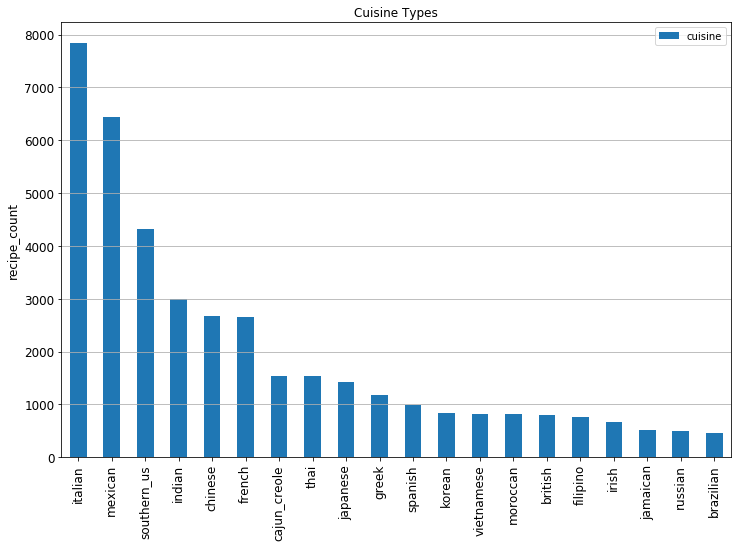

In [9]:
# Distribution of recipes across the cuisines in the training dataset
ax = df_train['cuisine'].value_counts().plot(kind='bar', title ="Cuisine Types", figsize=(12,8), legend=True, fontsize=12)
ax.set_ylabel("recipe_count", fontsize=12)
ax.grid('on', which='major', axis='y')
plt.show()

In [10]:
# Function to clean up the ingredients column in df_ingredients (see next code block)
cleanup_re = re.compile('[^a-z]+')
def clean_up(review):
    review = str(review)
    review = review.lower()
    review = cleanup_re.sub(' ', review).strip()
    return review

In [11]:
# Creating a dataframe with ingredients associated with each cuisine
ingredients_list=[]
for j in range(len(df_train)):
  for i in df_train.ingredients[j]:
    ingredients_list.append(i)
cuisine_list=[]
for j in range(len(df_train)):
  for i in df_train.ingredients[j]:
    cuisine_list.append(df_train.cuisine[j])

df_ingredients=pd.DataFrame(
    {
     'Cuisine': cuisine_list,
     'Ingredient_Name': ingredients_list
    })
df_ingredients['Ingredient_Name']=df_ingredients['Ingredient_Name'].apply(clean_up)  

In [12]:
df_ingredients.groupby('Cuisine').count()   #Count of Cuisines in the training dataset

,Ingredient_Name
Cuisine,
brazilian,4446
british,7806
cajun_creole,19506
chinese,32030
filipino,7550
french,25978
greek,11964
indian,38156
irish,6203


In [13]:
mat=pd.DataFrame(index=list(c.cuisine),columns=list(c.cuisine))
for j in mat.columns:
  for i in mat.index:
    s1=df_ingredients.loc[df_ingredients.Cuisine==i,'Ingredient_Name']
    s2=df_ingredients.loc[df_ingredients.Cuisine==j,'Ingredient_Name']
    mat.loc[i,j]=len(set(s1).intersection(set(s2)))     #calculating the count of common ingredients in cuisine i and j
  

In [14]:
mat.style.background_gradient(cmap='Blues')       #relation between various cusinies-- cell values are the count of the common ingredients used in both cuisine 

,brazilian,british,cajun_creole,chinese,filipino,french,greek,indian,irish,italian,jamaican,japanese,korean,mexican,moroccan,russian,southern_us,spanish,thai,vietnamese
brazilian,852,432,527,524,414,582,433,533,402,649,440,470,352,663,418,374,641,511,486,412
british,432,1165,586,590,401,812,522,621,584,846,443,515,355,749,482,515,819,572,465,395
cajun_creole,527,586,1573,774,532,953,695,751,571,1178,578,655,455,1121,567,535,1140,756,674,547
chinese,524,590,774,1791,655,880,626,879,524,1046,563,903,670,1062,601,508,996,659,949,815
filipino,414,401,532,655,947,561,417,570,360,636,438,565,440,663,397,369,642,464,578,532
french,582,812,953,880,561,2095,843,893,736,1535,585,761,518,1242,717,663,1286,936,745,613
greek,433,522,695,626,417,843,1196,717,493,989,457,547,402,882,618,486,836,668,575,457
indian,533,621,751,879,570,893,717,1661,564,1058,599,809,506,1054,701,541,1003,707,842,650
irish,402,584,571,524,360,736,493,564,996,770,416,461,328,712,453,466,764,533,434,353
italian,649,846,1178,1046,636,1535,989,1058,770,2921,662,872,585,1626,787,692,1548,1039,878,704


In [15]:
# A dataframe containing the top 3 similar cuisine for each of the 20 cuisines in the data imported
l1=[]
l2=[]
for i in mat.columns:
  for j in list(mat[i].drop([i]).nlargest(3).index): 
    l1.append(i)  #cuisine
    l2.append(j)  #similar cuisine

mat1=pd.DataFrame(
    {
     'Cuisine': l1,
     'Similar_Cuisine': l2
    })
mat1.set_index(['Cuisine','Similar_Cuisine'],inplace=True)
mat1

Empty DataFrame
Columns: []
Index: [(brazilian, mexican), (brazilian, italian), (brazilian, southern_us), (british, italian), (british, southern_us), (british, french), (cajun_creole, italian), (cajun_creole, southern_us), (cajun_creole, mexican), (chinese, mexican), (chinese, italian), (chinese, southern_us), (filipino, mexican), (filipino, chinese), (filipino, southern_us), (french, italian), (french, southern_us), (french, mexican), (greek, italian), (greek, mexican), (greek, french), (indian, italian), (indian, mexican), (indian, southern_us), (irish, italian), (irish, southern_us), (irish, french), (italian, mexican), (italian, southern_us), (italian, french), (jamaican, mexican), (jamaican, southern_us), (jamaican, italian), (japanese, chinese), (japanese, italian), (japanese, mexican), (korean, chinese), (korean, mexican), (korean, japanese), (mexican, italian), (mexican, southern_us), (mexican, french), (moroccan, italian), (moroccan, mexican), (moroccan, french), (russian, italian), (russian, french), (russian, mexican), (southern_us, italian), (southern_us, mexican), (southern_us, french), (spanish, italian), (spanish, mexican), (spanish, french), (thai, chinese), (thai, mexican), (thai, italian), (vietnamese, chinese), (vietnamese, thai), (vietnamese, mexican)]

In [16]:
# City of origin for each cuisine along with its latitude and longitude 
c['Geographical_Presence'] = ['Rio de Janeiro', 'London', 'Shreveport', 'Beijing', 'Manila', 'Paris', 'Athens', 'Delhi', 'Dublin', 'Rome', 'Kingston', 'Tokyo', 'Seoul', 'Mexico City'\
                              ,'Rabat', 'Moscow', 'Houston', 'Madrid','Bangkok', 'Hanoi'  ]
c['Latitude'] = [-22.911, 51.5001524, 32.513328, 39.9288889, 14.5893222, 48.8567879, 37.9833333, 28.6269628, 53.3441204, 41.8892943, 18.0179, 35.689506, 37.547895, \
                 19.4326, 34.02, 55.7615902, 29.759864, 40.4196202, 13.7539392, 21.028382]
c['Longitude'] = [-43.2094, -0.1262362, -93.7502, 116.3883333, 120.9811274, 2.3510768, 23.7333333, 77.2153959, -6.2673368, 12.4935467, -76.8099, 139.6917, 126.941893,\
                  -99.1333, -6.83, 37.60946, -95.369725, -3.6918167, 100.5012893, 105.853734]

c

,cuisine,recipe_count,Geographical_Presence,Latitude,Longitude
0,brazilian,467,Rio de Janeiro,-22.911000,-43.209400
1,british,804,London,51.500152,-0.126236
2,cajun_creole,1546,Shreveport,32.513328,-93.750200
3,chinese,2673,Beijing,39.928889,116.388333
4,filipino,755,Manila,14.589322,120.981127
5,french,2646,Paris,48.856788,2.351077
6,greek,1175,Athens,37.983333,23.733333
7,indian,3003,Delhi,28.626963,77.215396
8,irish,667,Dublin,53.344120,-6.267337
9,italian,7838,Rome,41.889294,12.493547


In [17]:
# Function calculating the distance between two locaitons using latitude and longitude coordinates
def distance(lat1,lon1,lat2,lon2):

    radius = 3959 # miles

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d   #distance in miles 

In [18]:
mat_dist=pd.DataFrame(index=list(c.cuisine),columns=list(c.cuisine)).astype(float)
for j in mat_dist.columns:
  for i in mat_dist.index:
    lat1=c.loc[c.cuisine==i,'Latitude'].tolist()[0]
    lon1=c.loc[c.cuisine==i,'Longitude'].tolist()[0]
    lat2=c.loc[c.cuisine==j,'Latitude'].tolist()[0]
    lon2=c.loc[c.cuisine==j,'Longitude'].tolist()[0]
    mat_dist.loc[i,j]=round(distance(lat1,lon1,lat2,lon2))                 #storing the distance values in miles in the mat_dist dataframe

In [19]:
mat_dist.style.background_gradient(cmap='Greens_r')       #relation between various cusinies-- cell values are the distance (in miles) between the country of origin of the cuisine
                                                          #the color gradeint is darker for smaller values as we are concerned with cuisines with close geographic proximity 

,brazilian,british,cajun_creole,chinese,filipino,french,greek,indian,irish,italian,jamaican,japanese,korean,mexican,moroccan,russian,southern_us,spanish,thai,vietnamese
brazilian,0,5766,5077,10763,11255,5698,6042,8746,5714,5717,3626,11538,11269,4773,4603,7175,5024,5060,9982,10454
british,5766,0,4644,5057,6672,213,1486,4170,288,891,4682,5940,5504,5549,1253,1554,4849,784,5923,5739
cajun_creole,5077,4644,0,7074,8455,4821,6124,8172,4356,5489,1453,6593,6933,963,4853,5699,213,4812,9105,8518
chinese,10763,5057,7074,0,1773,5104,4731,2347,5145,5048,8344,1301,592,7741,6176,3599,7209,5728,2049,1446
filipino,11255,6672,8455,1773,0,6677,5986,2955,6805,6458,9879,1862,1628,8837,7638,5132,8532,7243,1373,1089
french,5698,213,4821,5104,6677,0,1303,4093,485,687,4801,6035,5571,5715,1128,1545,5025,654,5868,5715
greek,6042,1486,6124,4731,5986,1303,0,3112,1774,653,6008,5906,5291,7010,1722,1386,6327,1472,4923,4922
indian,8746,4170,8172,2347,2955,4093,3112,0,4398,3677,8777,3627,2910,9108,4830,2698,8374,4519,1812,1866
irish,5714,288,4356,5145,6805,485,1774,4398,0,1172,4427,5956,5563,5264,1336,1737,4562,901,6126,5910
italian,5717,891,5489,5048,6458,687,653,3677,1172,0,5360,6124,5572,6364,1181,1477,5690,847,5487,5426


In [20]:
# A dataframe containing the top 3 cuisines which are at close geographic proximity for each of the 20 cuisines in the data imported
l1=[]
l2=[]
for i in mat_dist.columns:
  for j in list(mat_dist[i].drop([i]).nsmallest(3).index): 
    l1.append(i)  #cuisine
    l2.append(j)  #nearby cuisines

mat2=pd.DataFrame(
    {
     'Cuisine': l1,
     'Nearby_Cuisine': l2
    })
mat2.set_index(['Cuisine','Nearby_Cuisine'],inplace=True)
mat2

Empty DataFrame
Columns: []
Index: [(brazilian, jamaican), (brazilian, moroccan), (brazilian, mexican), (british, french), (british, irish), (british, spanish), (cajun_creole, southern_us), (cajun_creole, mexican), (cajun_creole, jamaican), (chinese, korean), (chinese, japanese), (chinese, vietnamese), (filipino, vietnamese), (filipino, thai), (filipino, korean), (french, british), (french, irish), (french, spanish), (greek, italian), (greek, french), (greek, russian), (indian, thai), (indian, vietnamese), (indian, chinese), (irish, british), (irish, french), (irish, spanish), (italian, greek), (italian, french), (italian, spanish), (jamaican, southern_us), (jamaican, cajun_creole), (jamaican, mexican), (japanese, korean), (japanese, chinese), (japanese, filipino), (korean, chinese), (korean, japanese), (korean, filipino), (mexican, southern_us), (mexican, cajun_creole), (mexican, jamaican), (moroccan, spanish), (moroccan, french), (moroccan, italian), (russian, greek), (russian, italian), (russian, french), (southern_us, cajun_creole), (southern_us, mexican), (southern_us, jamaican), (spanish, moroccan), (spanish, french), (spanish, british), (thai, vietnamese), (thai, filipino), (thai, indian), (vietnamese, thai), (vietnamese, filipino), (vietnamese, chinese)]

In [21]:
# Pairs of cuisines which are common to mat1 and mat2 i.e. Similar Cuisine dataframe and Nearby Cuisines dataframe respectively
df1=mat1.reset_index(level=['Cuisine', 'Similar_Cuisine'])
df2=mat2.reset_index(level=['Cuisine', 'Nearby_Cuisine'])

q1 = """SELECT df1.Cuisine,Similar_Cuisine,Nearby_Cuisine FROM df1 inner join df2 on df1.Cuisine=df2.Cuisine and df1.Similar_Cuisine=df2.Nearby_Cuisine"""

ps.sqldf(q1, locals())

,Cuisine,Similar_Cuisine,Nearby_Cuisine
0,brazilian,mexican,mexican
1,british,french,french
2,cajun_creole,southern_us,southern_us
3,cajun_creole,mexican,mexican
4,greek,italian,italian
5,greek,french,french
6,irish,french,french
7,italian,french,french
8,jamaican,mexican,mexican
9,jamaican,southern_us,southern_us


**So, from above the results, we conclude that amongst 60 pairs only 22 pairs exists in both dataframes. So the correlation between geographic proximity and similar ingredients is not high.**

In [22]:
#Multindex dataframe giving count of each ingredient in a cuisine
df=pd.DataFrame(df_ingredients.groupby(['Cuisine','Ingredient_Name'])['Ingredient_Name'].count())
df.rename(columns={'Ingredient_Name':'Count'},inplace=True)
df.head(20)                                                       

Count
Cuisine   Ingredient_Name                    
brazilian a ai                             14
          a ai powder                       5
          acai juice                        1
          active dry yeast                  3
          adobo style seasoning             1
          agave nectar                      4
          alcohol                           1
          all purpose flour                18
          all purpose unbleached flour      2
          allspice berries                  1
          almond butter                     3
          almond milk                       9
          amber                             1
          ancho powder                      1
          andouille sausage                 1
          anise seed                        1
          annatto                           1
          apple cider vinegar               1
          apple juice                       1
          apple pie spice                   1

In [23]:
df_ingredients['Ingredient_Name'].value_counts()

salt                                18049
olive oil                            7972
onions                               7972
water                                7457
garlic                               7380
                                    ...  
sauerkraut juice                        1
boned skinned duck breast halves        1
white creme de cacao                    1
white quinoa                            1
plum jam                                1
Name: Ingredient_Name, Length: 6686, dtype: int64

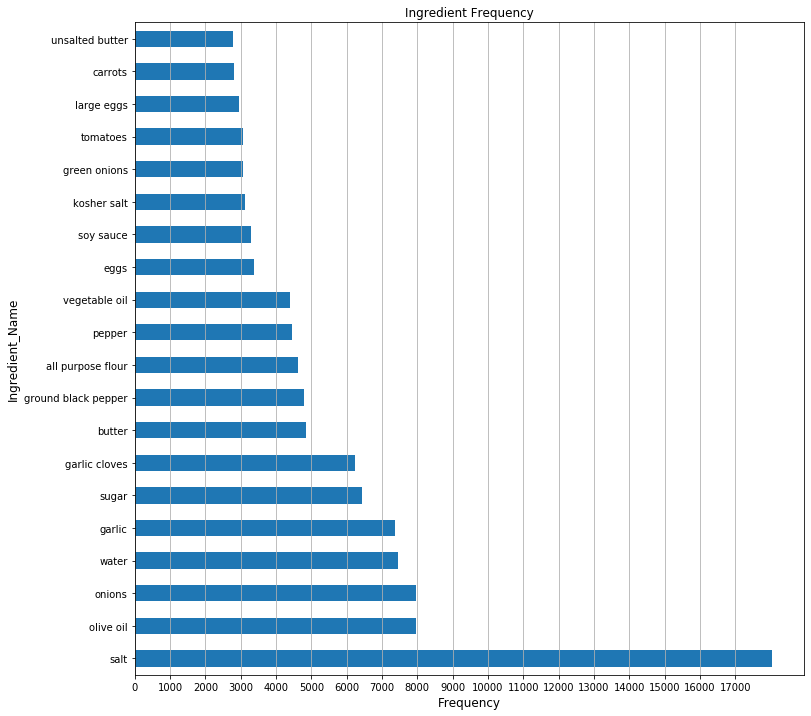

In [24]:
# Frequency of the Top 20 Ingredients used across cuisines
ax = df_ingredients['Ingredient_Name'].value_counts()[:20].plot(kind='barh', title ="Ingredient Frequency",figsize=(12,12), fontsize=10,xticks=np.arange(0, 18000, step=1000))
ax.set_ylabel("Ingredient_Name", fontsize=12)
ax.set_xlabel("Frequency",fontsize=12)
ax.grid('on', which='major', axis='x')
plt.show()

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 29130 entries, (brazilian, a ai) to (vietnamese, zucchini)
Data columns (total 1 columns):
Count    29130 non-null int64
dtypes: int64(1)
memory usage: 365.5+ KB


In [26]:
len(df_ingredients.groupby('Ingredient_Name'))    #number of unique ingredients in the training dataset

6686

In [27]:
#unique ingredients to a cuisine
q1 = """SELECT Ingredient_Name, Cuisine FROM df_ingredients group by Ingredient_Name having count(distinct Cuisine)=1"""

df_ingredients_unique=ps.sqldf(q1, locals())

In [28]:
df_ingredients_unique.head()

,Ingredient_Name,Cuisine
0,a ai,brazilian
1,a ai powder,brazilian
2,a taste of thai rice noodles,japanese
3,abalone,chinese
4,abbamele,italian


In [29]:
df_test = pd.read_json ('test.json')
df_test.head()

,id,ingredients
0,18009,"[baking powder, eggs, all-purpose flour, raisi..."
1,28583,"[sugar, egg yolks, corn starch, cream of tarta..."
2,41580,"[sausage links, fennel bulb, fronds, olive oil..."
3,29752,"[meat cuts, file powder, smoked sausage, okra,..."
4,35687,"[ground black pepper, salt, sausage casings, l..."


In [30]:
df_predict=df_test.copy()
df_predict['cuisine']=""
df_predict.head()

,id,ingredients,cuisine
0,18009,"[baking powder, eggs, all-purpose flour, raisi...",
1,28583,"[sugar, egg yolks, corn starch, cream of tarta...",
2,41580,"[sausage links, fennel bulb, fronds, olive oil...",
3,29752,"[meat cuts, file powder, smoked sausage, okra,...",
4,35687,"[ground black pepper, salt, sausage casings, l...",


In [31]:
##Predicting the cuisine for the recipes in the test dataset using df_ingredients_unique
for j in range(len(df_predict)):
  for i in df_predict.ingredients[j]:
    if i in list(df_ingredients_unique.Ingredient_Name):
      df_predict.loc[j,'cuisine']=df_ingredients_unique.loc[df_ingredients_unique.Ingredient_Name==i,'Cuisine'].tolist()[0]

In [32]:
(df_predict.cuisine!='').sum()            #count of recipes in the test dataset for which the cuisine was predicted 

1144

In [33]:
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9944 entries, 0 to 9943
Data columns (total 3 columns):
id             9944 non-null int64
ingredients    9944 non-null object
cuisine        9944 non-null object
dtypes: int64(1), object(2)
memory usage: 233.2+ KB


**As it can be seen from the above code blocks only 1144 recipes' cuisine (in the test data) were predicted which is unfortunately a low number as the test data has 9944 observations. Next, we will try implementing Linear Support Vector Classifier for prediciting the cuisines.**

# Modeling and Prediction

In [34]:
# A LinearSVC model pushes the accuracy score to 80%...checked on kaggle submission

df_train = pd.read_json('train.json')
df_train['ingredients_string'] = [(' '.join(lists)).strip() for lists in df_train['ingredients']]   


df_test = pd.read_json('test.json') 
df_test['ingredients_string'] = [(' '.join(lists)).strip() for lists in df_test['ingredients']]   

vectorizer_train = TfidfVectorizer(stop_words='english',
                             ngram_range = ( 1 , 1 ),analyzer="word", 
                             max_df = .57 , binary=False , token_pattern=r'\w+' , sublinear_tf=False)
tfidf_train=vectorizer_train.fit_transform(df_train['ingredients_string']).todense()
tfidf_test=vectorizer_train.transform(df_test['ingredients_string'])


parameters = {'C':[1, 10]}
clf = LinearSVC()


classifier = GridSearchCV(clf, parameters)
classifier=classifier.fit(tfidf_train,df_train['cuisine'])
predictions=classifier.predict(tfidf_test)
df_test['cuisine'] = predictions


C:\Users\mayan\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [35]:
df_test

,id,ingredients,ingredients_string,cuisine
0,18009,"[baking powder, eggs, all-purpose flour, raisi...",baking powder eggs all-purpose flour raisins m...,british
1,28583,"[sugar, egg yolks, corn starch, cream of tarta...",sugar egg yolks corn starch cream of tartar ba...,southern_us
2,41580,"[sausage links, fennel bulb, fronds, olive oil...",sausage links fennel bulb fronds olive oil cub...,italian
3,29752,"[meat cuts, file powder, smoked sausage, okra,...",meat cuts file powder smoked sausage okra shri...,cajun_creole
4,35687,"[ground black pepper, salt, sausage casings, l...",ground black pepper salt sausage casings leeks...,italian
...,...,...,...,...
9939,30246,"[large egg yolks, fresh lemon juice, sugar, bo...",large egg yolks fresh lemon juice sugar bourbo...,french
9940,36028,"[hot sauce, butter, sweet potatoes, adobo sauc...",hot sauce butter sweet potatoes adobo sauce salt,southern_us
9941,22339,"[black pepper, salt, parmigiano reggiano chees...",black pepper salt parmigiano reggiano cheese r...,italian
9942,42525,"[cheddar cheese, cayenne, paprika, plum tomato...",cheddar cheese cayenne paprika plum tomatoes g...,southern_us


In [38]:
df_test[['id','cuisine']].to_csv("submission.csv",index=False)